In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

data = pd.read_csv('./DATA/ZFOURGE/CDFS/CDFS_MAIN.csv', usecols=['Use', 'zpk', 'LIR', 'F24'])
CDFS = pd.DataFrame(data)
CDFS = CDFS[CDFS['Use'] == 1] # 13,299
CDFS = CDFS[CDFS['LIR'] > 0] # 8,486
CDFS['source'] = 'CDFS'

data = pd.read_csv('./DATA/ZFOURGE/COSMOS/COSMOS_MAIN.csv', usecols=['Use', 'zpk', 'LIR', 'F24'])
COSMOS = pd.DataFrame(data)
COSMOS = COSMOS[COSMOS['Use'] == 1] # 12,901
COSMOS = COSMOS[COSMOS['LIR'] > 0] # 7,954
COSMOS['source'] = 'COSMOS'

data = pd.read_csv('./DATA/ZFOURGE/UDS/UDS_MAIN.csv', usecols=['Use', 'zpk', 'LIR', 'F24'])
UDS = pd.DataFrame(data)
UDS = UDS[UDS['Use'] == 1] # 11,447
UDS = UDS[UDS['LIR'] > 0] # 6,557
UDS['source'] = 'UDS'

df = pd.concat([CDFS, COSMOS, UDS], ignore_index=True) # 22,997

In [170]:
redshift_bins = [(0, 0.3), (0.3, 0.45), (0.45, 0.6), (0.6, 0.8), 
                 (0.8, 1.0), (1.0, 1.2), (1.2, 1.7), (1.7, 2.0),
                 (2.0, 2.5), (2.5, 3.0), (3.0, 4.2), (4.2, 5.0),
                 (5.0, 6.0)] # redshift bins

percentiles = [25, 25, 25, 20,
               20, 20, 25, 20,
               20, 25, 50, 35,
               30]

fields = df['source'].unique()

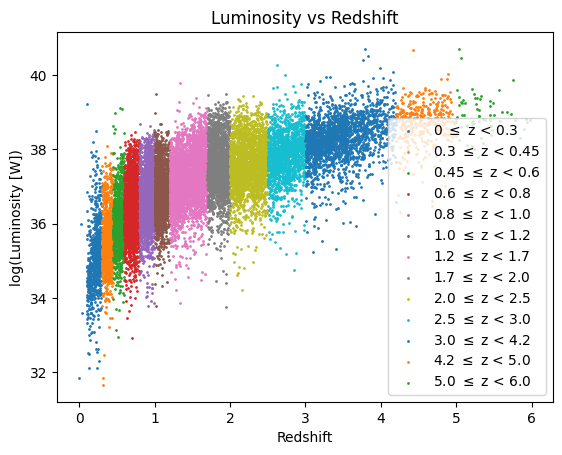

In [171]:
z = df['zpk'].values # redshift

lum = df['LIR'].copy().values # solar luminosity
lum *= 3.828 * 10 ** 26 # solar luminosity -> Watts

for z_start, z_end in redshift_bins:
    mask_z = (z >= z_start) & (z < z_end)
    plt.scatter(z[mask_z], np.log10(lum[mask_z]), s=1, label=f'{z_start} $\leq$ z < {z_end}')
plt.title('Luminosity vs Redshift')
plt.xlabel('Redshift')
plt.ylabel('log(Luminosity [W])')
plt.legend()
plt.show()

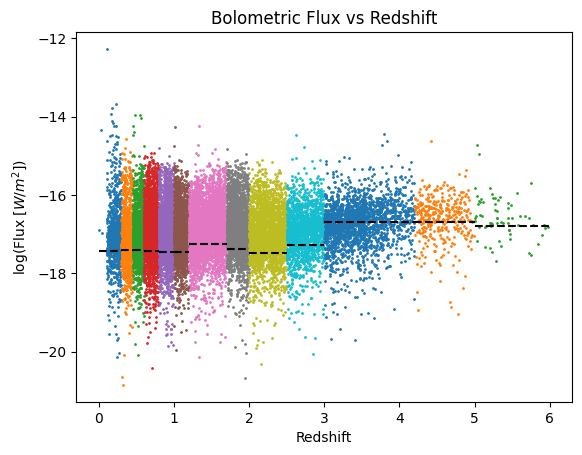

In [172]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
d_L = cosmo.luminosity_distance(z).to(u.m).value # m

F_bol = lum / (4 * np.pi * d_L ** 2) # W/m^2

F_lims = []
for (z_start, z_end), per in zip(redshift_bins, percentiles):
    mask_z = (z >= z_start) & (z < z_end)
    plt.scatter(z[mask_z], np.log10(F_bol[mask_z]), s=1, label=f'{z_start} $\leq$ z < {z_end}')
    p = np.percentile(F_bol[mask_z], per) # 80% of the data is above this value
    plt.hlines(np.log10(p), color='k', linestyle='--', label='Flux limit', xmin=z_start, xmax=z_end)
    F_lims.append(p)
plt.title('Bolometric Flux vs Redshift')
plt.ylabel('log(Flux [$W/m^2$])')
plt.xlabel('Redshift')
plt.show()

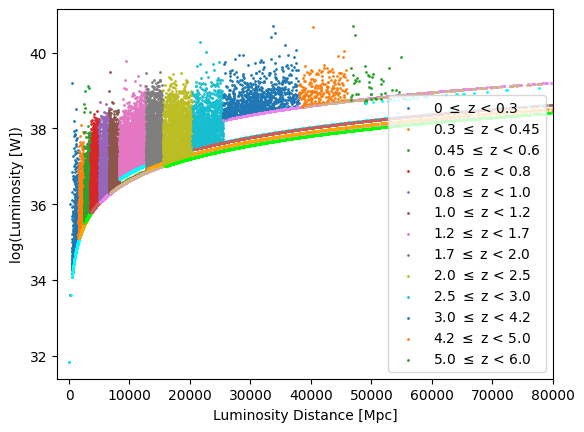

In [173]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
d_L = cosmo.luminosity_distance(z).value # Mpc
colours = ['cyan', 'orange', 'lime', 'indianred', 'violet', 'tan', 'cyan', 'orange', 'lime', 'indianred', 'violet', 'tan', 'cyan']

for (z_start, z_end), F_lim, c in zip(redshift_bins, F_lims, colours):
    mask_z = (z >= z_start) & (z < z_end)
    mask_flux = F_bol > F_lim
    plt.scatter(d_L[mask_z & mask_flux], np.log10(lum[mask_z & mask_flux]), s=1, label=f'{z_start} $\leq$ z < {z_end}')
    
    dmax = np.sqrt(lum[mask_z & mask_flux] / (4 * np.pi * F_lim)) # sqrt(W / W/m^2) = sqrt(m^2) = m
    dmax *= 3.241 * 10 **-23
    plt.scatter(dmax, np.log10(lum[mask_z & mask_flux]), s=1, color=c)
plt.ylabel('log(Luminosity [W])')
plt.xlabel('Luminosity Distance [Mpc]')
plt.xlim(-2000, 80000)
plt.legend()
plt.show()

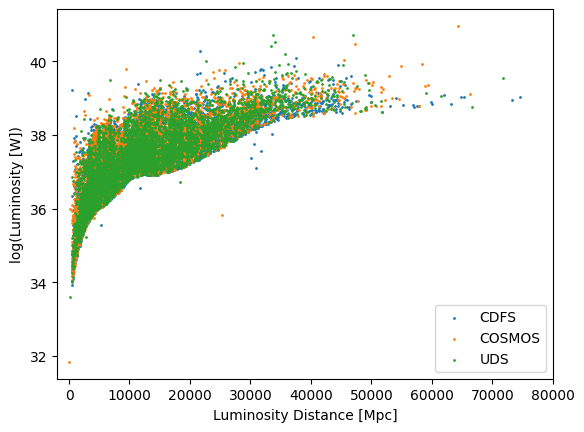

In [183]:
Flim = 0.003 # mJy
mask_flux = df['F24'] > Flim

lum_new = df['LIR'].copy().values # solar luminosity
lum_new *= 3.828 * 10 ** 26 # solar luminosity -> Watts

for f in fields:
    mask_f = df['source'] == f
    plt.scatter(d_L[mask_flux & mask_f], np.log10(lum_new[mask_flux & mask_f]), s=1, label=f)


cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
d_L = cosmo.luminosity_distance(z).value # Mpc
colours = ['cyan', 'orange', 'lime', 'indianred', 'violet', 'tan', 'cyan', 'orange', 'lime', 'indianred', 'violet', 'tan', 'cyan']

# for (z_start, z_end), F_lim, c in zip(redshift_bins, F_lims, colours):
#     mask_z = (z >= z_start) & (z < z_end)
#     mask_flux = F_bol > F_lim
    
    # dmaxs = np.sqrt(lum[mask_z & mask_flux] / (4 * np.pi * F_lim)) # sqrt(W / W/m^2) = sqrt(m^2) = m
    # dmaxs *= 3.241 * 10 **-23
    
    # rb_max = cosmo.luminosity_distance(z_end).value
    # mask_d = dmaxs <= rb_max
    
    # plt.scatter(dmaxs[mask_d], np.log10(lum[mask_z & mask_flux][mask_d]), s=1, color=c, label=f'{z_start} $\leq$ z < {z_end}')
    # plt.axvline(cosmo.luminosity_distance(z_end).value, color=c, linestyle='--')
    # plt.text(cosmo.luminosity_distance(z_end).value+1e3, max(np.log10(lum)), f'z = {z_end}', color=c)
plt.ylabel('log(Luminosity [W])')
plt.xlabel('Luminosity Distance [Mpc]')
plt.xlim(-2000, 80000)
plt.legend()
plt.show()